<a href="https://colab.research.google.com/github/mohamedalaaaz/testpytroch/blob/main/Maxwell%E2%80%99sequations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Neural network predicting E(x,t) and B(x,t)
class MaxwellNet(nn.Module):
    def __init__(self):
        super(MaxwellNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)  # Output: [E, B]
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

# Physics-informed loss
def maxwell_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True

    output = model(x, t)
    E = output[:, 0:1]
    B = output[:, 1:2]

    # Compute partial derivatives
    E_x = autograd.grad(E, x, torch.ones_like(E), retain_graph=True, create_graph=True)[0]
    E_t = autograd.grad(E, t, torch.ones_like(E), retain_graph=True, create_graph=True)[0]
    B_x = autograd.grad(B, x, torch.ones_like(B), retain_graph=True, create_graph=True)[0]
    B_t = autograd.grad(B, t, torch.ones_like(B), retain_graph=True, create_graph=True)[0]

    # Residuals of Maxwell's equations
    res1 = E_x + B_t  # ∂E/∂x + ∂B/∂t = 0
    res2 = B_x + E_t  # ∂B/∂x + ∂E/∂t = 0

    loss = torch.mean(res1**2 + res2**2)
    return loss

# Training loop
def train(model, epochs=5000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        # Sample (x, t) in domain
        x = torch.rand(1000, 1, device=device)
        t = torch.rand(1000, 1, device=device)

        loss = maxwell_loss(model, x, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Instantiate and train the model
model = MaxwellNet().to(device)
train(model)


Epoch 0, Loss: 0.002974
Epoch 500, Loss: 0.000001
Epoch 1000, Loss: 0.000002
Epoch 1500, Loss: 0.000001
Epoch 2000, Loss: 0.000051
Epoch 2500, Loss: 0.000000
Epoch 3000, Loss: 0.000001
Epoch 3500, Loss: 0.000002
Epoch 4000, Loss: 0.000000
Epoch 4500, Loss: 0.000000


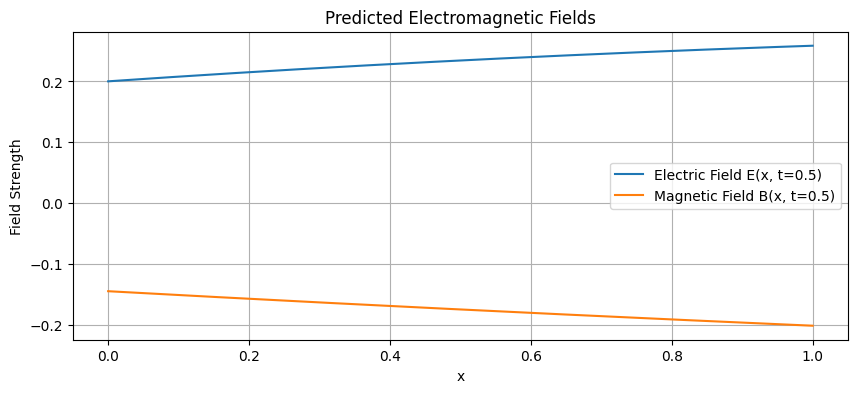

In [2]:
# Visualize E(x, t) and B(x, t) at t = 0.5
x_test = torch.linspace(0, 1, 200).view(-1, 1).to(device)
t_test = torch.full_like(x_test, 0.5)

with torch.no_grad():
    output = model(x_test, t_test).cpu()
    E = output[:, 0]
    B = output[:, 1]

plt.figure(figsize=(10, 4))
plt.plot(x_test.cpu(), E, label='Electric Field E(x, t=0.5)')
plt.plot(x_test.cpu(), B, label='Magnetic Field B(x, t=0.5)')
plt.title("Predicted Electromagnetic Fields")
plt.xlabel("x")
plt.ylabel("Field Strength")
plt.grid(True)
plt.legend()
plt.show()
